<a href="https://colab.research.google.com/github/cheul0518/Self-projects/blob/main/GAN/Mnist(draft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Dropout, LeakyReLU
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%load_ext tensorboard

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
    #print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    tf.compat.v1.disable_eager_execution() # Tensor.graph is meaningless when eager execution is enabled    
    print('Running on TPU:', tpu.master())    
except ValueError:
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

print(f"Running on {strategy.num_replicas_in_sync} replicas")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.70.131.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.70.131.194:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.70.131.194:8470
Running on 8 replicas


In [4]:
HEIGHT = 28
WIDTH = 28
CHANNELS = 1
IMG_SHAPE = (HEIGHT, WIDTH, CHANNELS)

def discriminator():
    """ Create a discriminator
    """
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=IMG_SHAPE))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())    
    model.add(Dense(1, activation = 'sigmoid'))    
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model


# Effective way to achieve transformation from e.g 100 dimensions to a 28 x 28 dimentions
# 1) Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image
# 2) Build many parallel filters resulting in different learned features that can be combined together into a final image
def generator(noise_dim):
    """ noise_dim: noise dimension
        Created a generator
    """
    model = Sequential()
    model.add(Dense(128 * int(HEIGHT/4) * int(WIDTH/4), input_dim = noise_dim)) # (HEIGHT/4) x (WIDTH/4) image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((int(HEIGHT/4), int(WIDTH/4), 128)))    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Upsample to (HEIGHT/2) x (WIDTH/2)
    # Why even-sized kernel here? Used a kernel size that is a factor of the stride to avoid a checkerboard pattern that can be observed when upsampling
    # Reference: https://distill.pub/2016/deconv-checkerboard/
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) # Upsame to (HEIGHT) x (WIDTH)
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same')) # a feature map of 28 x 28. Sigmoid is used to keep every element value to be within [0,1]    
    return model

def gan(gen, dis):
    """ gen: generator model, dis: discriminator model
    """
    dis.trainable = False
    model =Sequential()
    model.add(gen)
    model.add(dis)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

def load_dataset():
    """ 
    Load MNIST dataset from Keras.datasets and unpack it
    """
    (X_train, _), (_ , _) = mnist.load_data() # X_train, y_train, X_test, y_test
    X_train = (X_train.astype(np.float32))/255 # Convert uint8 to float32 and rescale (0, 1)
    X_train = np.expand_dims(X_train, axis = -1) # Add a dimension for channel
    return X_train    

def generate_samples(dataset, model, noise_dim, n):
    """ dataset: dataset, model: model, noise_dim: noise dimension, n: the number of samples
    Generate n number of samples in noise dimension from dataset and model
    """ 
    # real samples
    i = np.random.randint(0, dataset.shape[0], n)    
    X_real = dataset[i]
    y_real = np.ones((n, 1))
    # fake samples
    #X = np.random.rand(n, noise_dim)
    X_fake = model.predict(np.random.randn(n, noise_dim))
    y_fake = np.zeros((n, 1))
    return X_real, y_real, X_fake, y_fake

def save_plot(examples, epoch, n =10):
    """ 
    """
    for i in range(n * n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

def summary(dataset, gen, dis, epoch, noise_dim, n):
    """ dataset: dataset, gen: generator, dis: discriminator, epoch: epoch, noise_dim: noise dimension, n: # of samples
    """
    X_real, y_real, X_fake, y_fake = generate_samples(dataset, gen, noise_dim, n)
    acc_real = dis.evaluate(X_real, y_real, verbose=0)
    acc_fake = dis.evaluate(X_fake, y_fake, verbose=0)
    print(f'{100 * acc_real}% {100 * acc_fake}%')
    save_plot(X_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    gen.save(filename)

def train(dataset, gen, dis, gan, noise_dim, epochs=100, batch_size=256):
    """ dataset: dataset, gen: generator, dis: discriminator, gan: GAN, noise_dim: noise dimension, epochs: # of epochs, batch: batch size
    """
    batch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size/2)
    # Add functionality of numpy.random.shuffle (shuffle along the first axis:  concat X,y, shuffle, and split)
    for i in range(epochs):
        for j in range(batch):
            X_real, y_real, X_fake, y_fake = generate_samples(dataset, gen, noise_dim, half_batch)
            X, y = np.vstack((X_real,X_fake)), np.vstack((y_real, y_fake))
            dLoss = dis.train_on_batch(X, y) # update the discriminator weights
            X_gan = np.random.randn(batch_size, noise_dim)
            y_gan = np.ones((batch_size, 1))
            gLoss = gan.train_on_batch(X_gan, y_gan) # update the generator weights via the discriminator's error
            print(f'{i+1} {j+1} {batch} {dLoss:.3f} {gLoss:.3f}')
        if (i+1) % 10 == 0:
            summary(dataset, gen, dis, i, noise_dim, half_batch)

In [6]:
noise_dim = 100
dis = discriminator()
gen = generator(noise_dim)
gan = gan(gen, dis)
dataset = load_dataset()
train(dataset, gen, dis, gan, noise_dim)

AttributeError: ignored

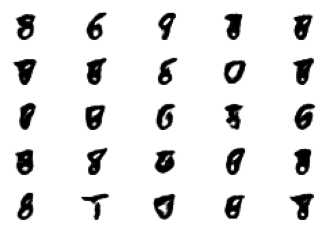

In [16]:
import numpy as np
from keras.models import load_model
from matplotlib import pyplot

def save_plot(examples, n):
    for i in range(n*n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

model = load_model('generator_model_090.h5')
noise = np.random.rand(25, 100)
X = model.predict(noise)
save_plot(X, 5)

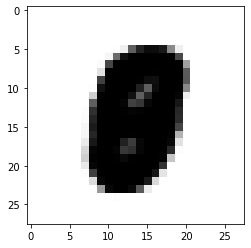

In [17]:
vector = np.asarray([[0.0 for _ in range(100)]])
X = model.predict(vector)
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()